# Local Tetra Pattern  and Local Tetra Micro-structure Pattern

## The LTrP algorithm can be broken down into the following stages:
1. Compute required derivatives - horizontal and vertical
2. Apply rules for LTrP1 code (4 possible orientations)
3. Determine the P-components for every g_c pixel in LTrP1
4. Assemble all the P-components (final LTrP2 code)

## Comparatively, the LMTrP used for palmprint recognition considers the following stages:
1. Extract either magnitude of response to Gabor filter bank (12 orientations,sigma=1.5 using min rule) or response to RLOC bank of filters (same min rule applied). In this example we will only use Gabor filters.
2. Apply modified derivative, according to the LMTrP rule (using m1 and m2 for 'line width')
3. Apply rules for LMTrP1, the same as for LTrP1 -> same as **LTrP-step2**
4. Determine the P-components for every g_c pixel in LMTrP1 -> same as **LTrP-step3**
5. Assemble all the P-components (intermediate LMTrP2 code) -> same as **LTrP-step4**
6. For every P-component (12 in total), split the corresponding image into 8x8 blocks (initial paper uses 5x5 blocks)
7. Compute histogram for pixels in each block. Number of bins=8, range of values=[0,255]. Paper does not mention these parameters...
8. Concatenate each histogram row-wise
9. Concatenate all block-histogram feature corresponding to every P-component into one matrix
10. Apply Kernel-PCA to reduce the number of components. Number of components=15.
11. **Display and enjoy the feature :)**

## First let's implement the LTrP -> applied to a palmprint

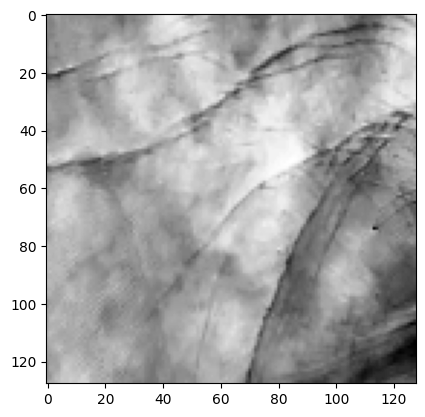

In [47]:
# importing some libraries...
import numpy as np, matplotlib.pyplot as plt, cv2
import time
from functools import reduce
im_side = 128
image = cv2.imread('1_001.bmp')
#Đánh giá mô hình dataset RGB hay Grey không quan trọng vì trong bộ encode nó đã chuyển ảnh sang grey
#Giảm kích thước ảnh => giảm t/g xử lý?
#print('Original image shape:', image.shape)
#Anh grey là ma trận 2 chiều => Nó chỉ cần 1 giá trị độ xám (intensity) duy nhất thay vì 3 giá trị RGB => Mảng 3 chiều
#Chuyển dữ liệu sang grey
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#Thay đổi kích thước ảnh 64x64
image = cv2.resize(image, (im_side, im_side))
image = np.array(image, dtype=np.float32)  # /255.

plt.imshow(image,cmap='gray')
plt.show()

## [LTrP] - Step1 - Compute derivative

In [37]:
###################################################################

#Đạo hàm của hình ảnh ban đầu theo hướng ngang và dọc
def derivate_image(im, angle):
    '''
    Compute derivative of input image
    :param im: input image. should be grayscale!
    :param angle: 0 or 90 degrees
    :return: computed derivative along that direction.
    includes padding...
    '''
    h, w = np.shape(im)
    pad_im = np.pad(im, (1, 0), 'edge')
    if angle == 'horizontal':  # horizontal derivative
        deriv_im = pad_im[1:, :w] - im  # [1:, :w]
    elif angle == 'vertical':
        deriv_im = pad_im[:h, 1:] - im  # [1:, :w]

    return deriv_im

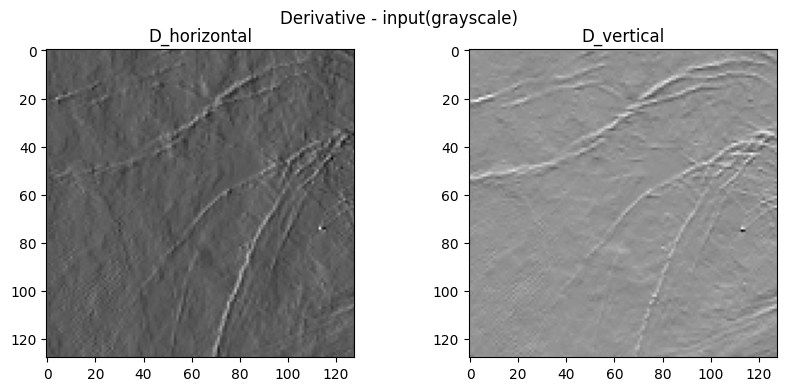

In [38]:
deriv_h = derivate_image(im=image, angle='horizontal')
deriv_v = derivate_image(im=image, angle='vertical')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(deriv_h,'gray')
plt.title('D_horizontal')
plt.subplot(122)
plt.imshow(deriv_v,'gray')
plt.title('D_vertical')
plt.suptitle('Derivative - input(grayscale)')
plt.show()

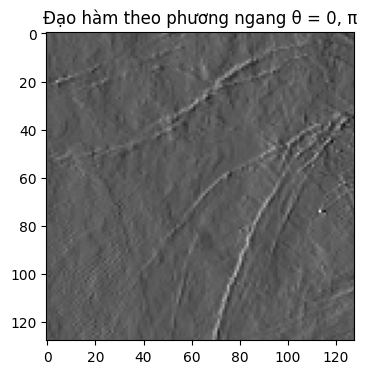

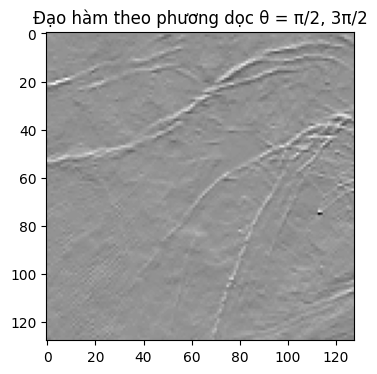

In [39]:
deriv_h = derivate_image(im=image, angle='horizontal')
deriv_v = derivate_image(im=image, angle='vertical')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(deriv_h,'gray')
plt.title('Đạo hàm theo phương ngang θ = 0, π')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(122)
plt.imshow(deriv_v,'gray')
plt.title('Đạo hàm theo phương dọc θ = π/2, 3π/2')
plt.show()

## [LTrP] - Step2 - Compute LTrP1 code

In [40]:
###################################################################
def extract_ltrp1(im_d_x, im_d_y):
    """
    Extract LTrP1 code (4 orientations) by using input dx and dy matrices.
    ###################################################################
    Implemented by: Adrian Ungureanu - June 2019. If you use this script, please reference the source code (and send me
    an e-mail. I would be happy to hear about other people's success using my code (: )
    ###################################################################
    :param im_d_x: derivative of image according to x axis (horizontal)
    :param im_d_y: derivative of image according to y axis (vertical)
    :return: encoded LTrP1 code. Possible values ={1,2,3,4}
    """
    encoded_image = np.zeros(np.shape(im_d_y))  # define empty matrix, of the same shape as the image...

    # # apply conditions for each orientation...
    encoded_image[np.bitwise_and(im_d_x >= 0, im_d_y >= 0)] = 1
    encoded_image[np.bitwise_and(im_d_x < 0, im_d_y >= 0)] = 2
    encoded_image[np.bitwise_and(im_d_x < 0, im_d_y < 0)] = 3
    encoded_image[np.bitwise_and(im_d_x >= 0, im_d_y < 0)] = 4

    return encoded_image

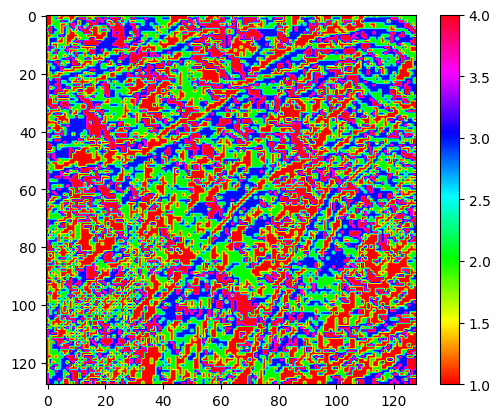

In [41]:
# # Extract LTrP1 code...
ltrp1 = extract_ltrp1(im_d_x=deriv_h, im_d_y=deriv_v)

plt.imshow(ltrp1,'hsv')
plt.colorbar()
plt.show()

## [LTrP] - Step 3&4 - Extract P-components (LTrP2)

In [55]:
###################################################################
def extract_ltrp2(ltrp1_code, plotting_flag=True):
    """
    Extracting the P-components for every pixel (g_c), as defined in the original paper by S. Murala, R. P. Maheshwari
    and R. Balasubramanian (2012), "Local Tetra Patterns: A New Feature Descriptor for Content-Based Image Retrieval,"
    in IEEE Transactions on Image Processing, vol. 21, no. 5, pp. 2874-2886, May 2012. doi: 10.1109/TIP.2012.2188809.
    This implementation does not consider the MAGNITUDE, but that feature can be easily implemented...
    ###################################################################
    Implemented by: Adrian Ungureanu - June 2019. If you use this script, please reference the source code (and send me
    an e-mail. I would be happy to hear about other people's success using my code (: )
    ###################################################################
    :param ltrp1_code: previously computed LTrP1 code (with 4 possible orientations)
    :param plotting_flag: whether or not to display the P-components of the LTrP
    :return: the P-components stacked together. Output shape = (12, image_size, image_size)
    """
#LTRP1: một điểm ảnh có thể được mã hóa thành 4 giá tri {1,2,3,4}
#Mỗi giá trị mã hóa được chuyển thành 3 mẫu nhị phân => 12 mẫu
#Mỗi điểm ảnh tham chiếu sẽ có 8 pixel liền kề => 8 bit mẫu cục bộ
    this_im_side = np.shape(ltrp1_code)[0]
    ltrp1_code = np.pad(ltrp1_code, (1, 1), 'constant', constant_values=0)
    g_c1 = np.zeros((3, this_im_side, this_im_side))
    g_c2 = np.zeros((3, this_im_side, this_im_side))
    g_c3 = np.zeros((3, this_im_side, this_im_side))
    g_c4 = np.zeros((3, this_im_side, this_im_side))

    for i in range(1, im_side+1):
        for j in range(1, im_side+1):
            g_c = ltrp1_code[i, j]

            # # extract neighborhood around g_c pixel
            neighborhood = np.array([ltrp1_code[i + 1, j], ltrp1_code[i + 1, j - 11], ltrp1_code[i, j - 11],
                                     ltrp1_code[i - 1, j - 1], ltrp1_code[i - 1, j], ltrp1_code[i - 1, j + 1],
                                     ltrp1_code[i, j + 1], ltrp1_code[i + 1, j + 1]])
            # # determine the codes that are different from g_c
            mask = neighborhood != g_c
            # # apply mask
            ltrp2_local = np.multiply(neighborhood, mask)

            # # construct P-components for every orientation.
            if g_c == 1:
                for direction_index, direction in enumerate([2, 3, 4]):
                    g_dir = ltrp2_local == direction
                    g_c1[direction_index, i - 1, j - 1] = reduce(lambda a, b: 2 * a + b, np.array(g_dir, dtype=np.int))

            elif g_c == 2:
                for direction_index, direction in enumerate([1, 3, 4]):
                    g_dir = ltrp2_local == direction
                    g_c2[direction_index, i - 1, j - 1] = reduce(lambda a, b: 2 * a + b, np.array(g_dir, dtype=np.int))

            elif g_c == 3:
                for direction_index, direction in enumerate([1, 2, 4]):
                    g_dir = ltrp2_local == direction
                    g_c3[direction_index, i - 1, j - 1] = reduce(lambda a, b: 2 * a + b, np.array(g_dir, dtype=np.int))

            elif g_c == 4:
                for direction_index, direction in enumerate([1, 2, 3]):
                    g_dir = ltrp2_local == direction

                    g_c4[direction_index, i - 1, j - 1] = reduce(lambda a, b: 2 * a + b, np.array(g_dir, dtype=np.int))
                    pass

            elif g_c not in [1, 2, 3, 4]:
                raise Exception('Error - Invalid value for g_c. List of possible values include [1,2,3,4].')

    # # collect all P-components in a 'large_g_c'
    large_g_c = []
    for this_g_c in [g_c1, g_c2, g_c3, g_c4]:
        large_g_c.extend(this_g_c)
    large_g_c = np.array(large_g_c)

    if plotting_flag:
        map = 'gray'

        p_counter = 0
        p_code_counter = 0
        plt.figure(figsize=(16, 8))
        for index in range(12):
            plt.subplot(3, 4, index + 1)
            plt.imshow(large_g_c[index, :, :], cmap=map)
            plt.title('P%d - %d' % (p_counter + 1, p_code_counter + 1))

            p_counter += 1
            p_code_counter += 1

            if p_counter % 4 == 0:
                p_counter = 0
            if p_code_counter % 3 == 0:
                p_code_counter = 0
        plt.tight_layout()
        plt.show()

    return large_g_c

C:\Users\Admin\AppData\Local\Temp\ipykernel_10916\821999345.py:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g_c1[direction_index, i - 1, j - 1] = reduce(lambda a, b: 2 * a + b, np.array(g_dir, dtype=np.int))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10916\821999345.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision

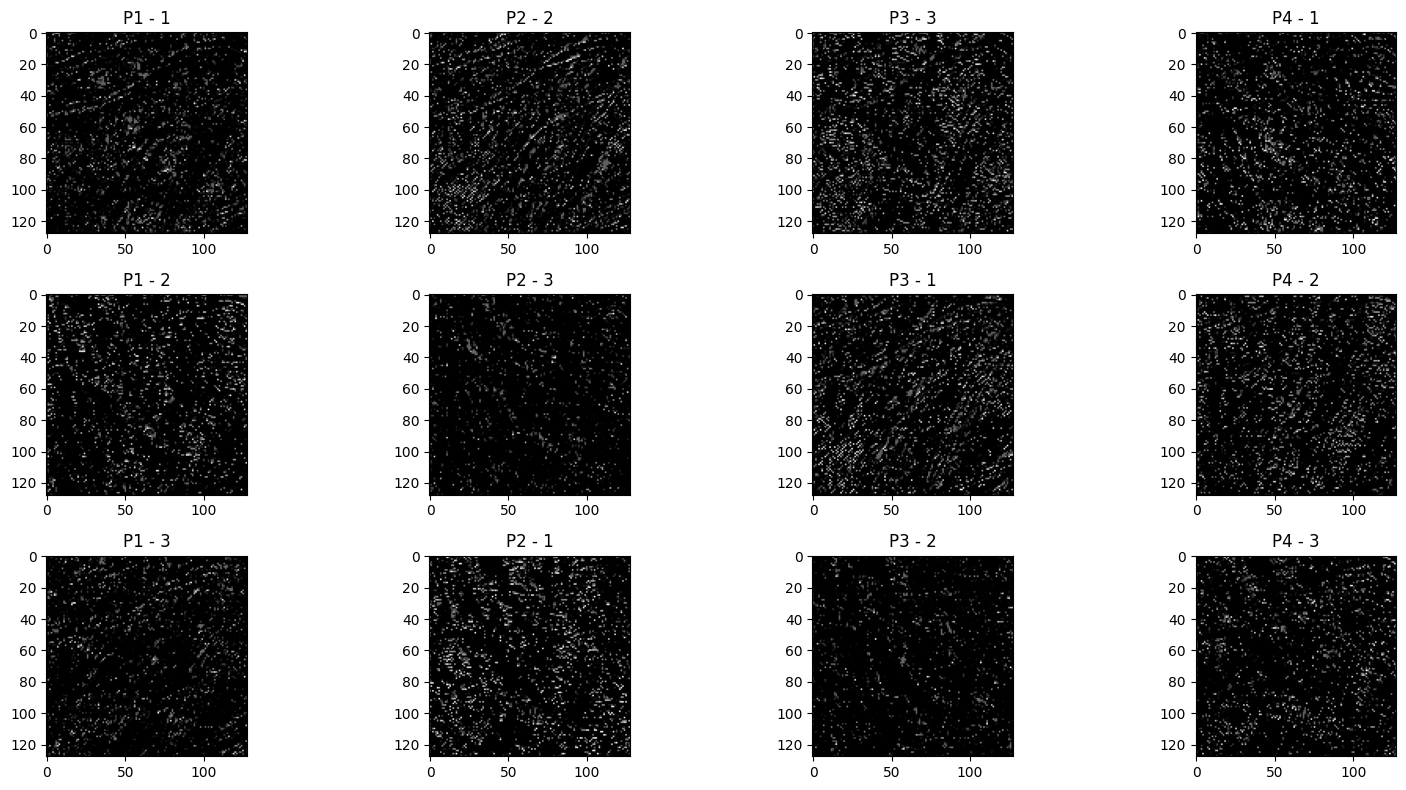

(12, 128, 128)


In [56]:
plot_figures_flag=True
ltrp2 = extract_ltrp2(ltrp1_code=ltrp1, plotting_flag=plot_figures_flag)
print(np.shape(ltrp2))

## [LMTrP] - Step1 - get Gabor filter response

In [5]:
# some useful functions...
from functools import reduce
from sklearn.decomposition import KernelPCA
from scipy.signal import convolve2d

########################################################################################################################
def extract_compcode_with_magnitude(input_image, no_theta=6, sigma=1.5):
    """
    Extract Competitive Coding Scheme with 6 Gabor filters (orientations), as was defined by A. W. -. Kong and D. Zhang
    (2004) in "Competitive coding scheme for palmprint verification," doi: 10.1109/ICPR.2004.1334184.
    ###################################################################
    The Python implementation is based on the Matlab implementation provided by Zohaib Khan, Ajmal Mian and Yiqun Hu,
    "Contour Code: Robust and efficient multispectral palmprint encoding for human recognition,"
    Computer Vision (ICCV), 2011 IEEE International Conference on , vol., no., pp.1935-1942, 6-13 Nov. 2011
    ###################################################################
    Implemented by: Adrian Ungureanu - June 2019. If you use this script, please reference the source code (and send me
    an e-mail. I would be happy to hear about other people's success using my code (: )
    ###################################################################
    :param input_image: input image. expected to be Grayscale
    :param sigma: width of encoding line. Default value = 1.5
    :return: CompCode feature with 6 orientations (default). Output shape = same as input.
    """
    theta = np.arange(1, no_theta + 1) * np.pi / no_theta
    (x, y) = np.meshgrid(np.arange(0, 35, 1), np.arange(0, 35, 1))
    xo, yo = np.shape(x)[0] / 2, np.shape(x)[0] / 2
    kappa = np.sqrt(2. * np.log(2.)) * ((np.power(2, sigma) + 1.) / ((np.power(2, sigma) - 1.)))
    omega = kappa / sigma

    Psi = {}  # where the filters are stored
    gabor_responses = []
    for i in range(0, len(theta)):
        xp = (x - xo) * np.cos(theta[i]) + (y - yo) * np.sin(theta[i])
        yp = -(x - xo) * np.sin(theta[i]) + (y - yo) * np.cos(theta[i])
        # Directional Gabor Filter
        Psi[str(i)] = (-omega / (np.sqrt(2 * np.pi)) * kappa) * \
                      np.exp(
                          (-np.power(omega, 2) / (8 * np.power(kappa, 2))) * (4 * np.power(xp, 2) + np.power(yp, 2))) * \
                      (np.cos(omega * xp) - np.exp(-np.power(kappa, 2) / 2))

        # # used for debugging... #1
        # plt.subplot(2,3,i+1)
        # plt.imshow(Psi[str(i)], cmap='jet')
        filtered = convolve2d(input_image, Psi[str(i)], mode='same', boundary='symm')
        # # used for debugging #2
        # plt.imshow(filtered)
        # plt.show()
        gabor_responses.append(filtered)

    # plt.show() #1
    gabor_responses = np.array(gabor_responses)

    compcode_orientations = np.argmin(gabor_responses, axis=0)
    compcode_magnitude = np.min(gabor_responses, axis=0)

    return compcode_orientations, compcode_magnitude

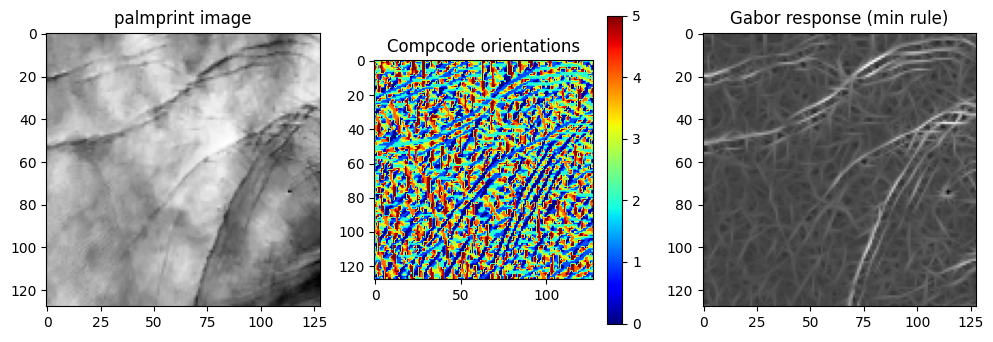

In [18]:
compcode_orientations, compcode_magnitude = extract_compcode_with_magnitude(image)

compcode_magnitude = (compcode_magnitude - np.max(np.max(compcode_magnitude))) * -1
compcode_magnitude = (compcode_magnitude / np.max(np.max(compcode_magnitude))) * 255

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('palmprint image')
plt.subplot(132)
plt.imshow(compcode_orientations, cmap='jet')
plt.colorbar()
plt.title('Compcode orientations')
plt.subplot(133)
plt.imshow(compcode_magnitude, cmap='gray')
plt.title('Gabor response (min rule)')
plt.show()

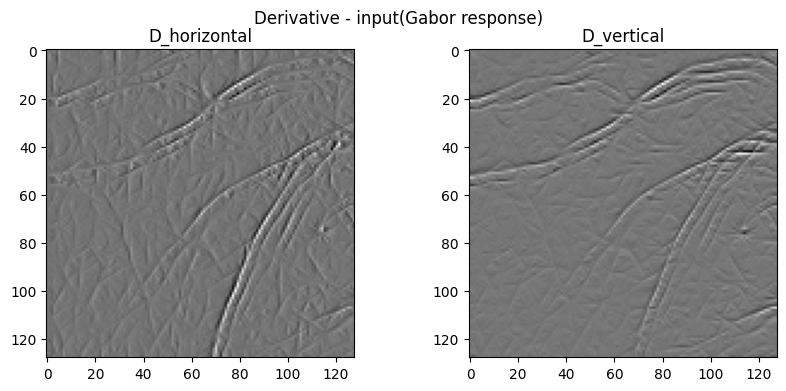

In [19]:
# # using standard image derivation (like in LTrP)
deriv_h = derivate_image(im=compcode_magnitude, angle='horizontal')
deriv_v = derivate_image(im=compcode_magnitude, angle='vertical')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(deriv_h,'gray')
plt.title('D_horizontal')
plt.subplot(122)
plt.imshow(deriv_v,'gray')
plt.title('D_vertical')
plt.suptitle('Derivative - input(Gabor response)')
plt.show()

## [LMTrP] - Step2 - Compute image derivative (4 palmprint)

In [20]:
###################################################################
def derivate_image_palm_line(im, angle, m1=3, m2=1, N1=3, N2=4):
    """
    Compute derivative of input image 'im' (grayscale!) along the direction indicated by 'angle'.
    As defined by Li, Gen & Kim, Jaihie (2016) in their paper 'Palmprint Recognition with Local Micro-structure Tetra Pattern',
    published in Pattern Recognition. 61. 10.1016/j.patcog.2016.06.025.
    ###################################################################
    Implemented by: Adrian Ungureanu - June 2019. If you use this script, please reference the source code (and send me
     an e-mail. I would be happy to hear about other people's success using my code (: )
    ###################################################################
    :param im: input image
    :param angle: direction along which the derivative is computed. Either 'horizontal' (dx) or 'vertical' (dy)
    :param m1: thickness of pixels adjiacent to g_c along 'theta' direction (first structure)
    :param m2: thickness of pixels adjiacent to g_c along 'beta' direction (second structure)
    :param N1: number of pixels adjiacent to g_c along 'theta' direction. In this implementation it is considered to be
    equal to (m1+1)
    :param N2: number of pixels adjiacent to g_c along 'beta' direction. In this implementation it is considered to be
    equal to (m2*4)
    :return: the derivative of the image, which is required to compute the Local Tetra Pattern. output shape(same as input
    image)
    """
    pad_im = np.pad(im, (m2, m1), 'edge')  # image needs to be padded to the right and bellow.
    h, w = np.shape(pad_im)

    deriv_im = np.zeros(np.shape(im))

    if angle == 'horizontal':
        # # moving window across the image...
        for i in range(m2, h - m1):
            for j in range(m2, w - m1):
                g_c = pad_im[i, j]  # current g_c
                e1_sum = 0  # used for first sum in the equation
                for k in range(0, m1):
                    e1_sum += pad_im[i, j + k]
                element1 = (e1_sum + g_c) / float((m1 + 1))  # initially had N1 in the last paranthesis.
                # efficiently replaced with (m1+1)

                e2_sum = 0  # used for second sum in the equation
                for k in range(0, m2):
                    e2_sum += (pad_im[i, j + k] + pad_im[i - k, j] + pad_im[i - k, j] + pad_im[
                        i + k, j])  # (pad_im[i,j+k] + pad_im[i,j-k])
                element2 = e2_sum / float(m2 * 4)  # initially had N2 in the last paranthesis.
                # efficiently replaced with (m2*4)

                # # used for debugging
                # res = element1 - element2

                deriv_im[i - m2, j - m2] = element1 - element2

    elif angle == 'vertical':
        # # moving window across the image...
        for i in range(m2, h - m1):
            for j in range(m2, w - m1):
                g_c = pad_im[i, j]  # current g_c
                e1_sum = 0  # used for first sum in the equation
                for k in range(0, m1):
                    e1_sum += pad_im[i + k, j]
                    # + (pad_im[i, j + k] + pad_im[i - k, j] + pad_im[i - k, j] + pad_im[i + k, j])

                element1 = (e1_sum + g_c) / float((m1 + 1))  # initially had N1 in the last paranthesis.
                # efficiently replaced with (m1+1)

                e2_sum = 0  # used for second sum in the equation
                for k in range(0, m2):
                    e2_sum += (pad_im[i, j + k] + pad_im[i - k, j] + pad_im[i - k, j] + pad_im[
                        i + k, j])  # + (pad_im[i+k, j] + pad_im[i+k, j])
                element2 = e2_sum / float(m2 * 4)  # initially had N2 in the last paranthesis.
                # efficiently replaced with (m2*4)

                # # used for debugging
                # res = element1 - element2
                deriv_im[i - m2, j - m2] = element1 - element2

    return deriv_im

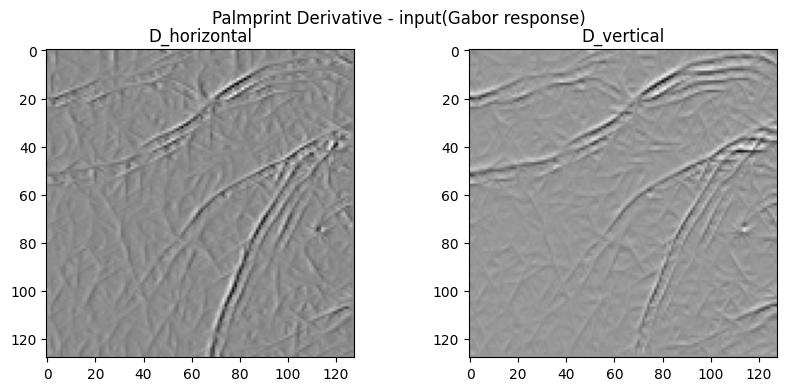

In [21]:
deriv_h = derivate_image_palm_line(im=compcode_magnitude, angle='horizontal', m1=3, m2=1)
deriv_v = derivate_image_palm_line(im=compcode_magnitude, angle='vertical', m1=3, m2=1)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(deriv_h,'gray')
plt.title('D_horizontal')
plt.subplot(122)
plt.imshow(deriv_v,'gray')
plt.title('D_vertical')
plt.suptitle('Palmprint Derivative - input(Gabor response)')
plt.show()

## [LMTrP] - Steps 3 - Extract LMTrP1 (function already defined)

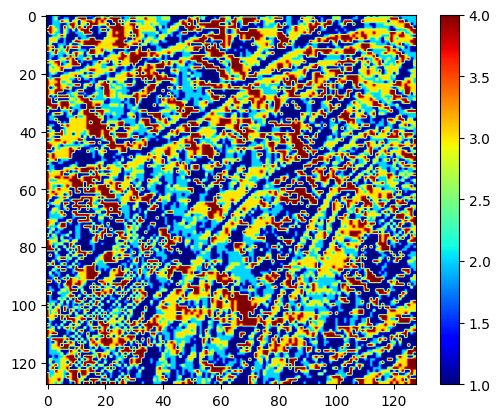

In [49]:
# # Extract LMTrP1 code...
ltrp1 = extract_ltrp1(im_d_x=deriv_h, im_d_y=deriv_v)

plt.imshow(ltrp1,cmap='jet')
plt.colorbar()
plt.show()

## [LMTrP] - Steps 4&5 - Extract P-components (LMTrP2)

C:\Users\Admin\AppData\Local\Temp\ipykernel_10916\821999345.py:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g_c1[direction_index, i - 1, j - 1] = reduce(lambda a, b: 2 * a + b, np.array(g_dir, dtype=np.int))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10916\821999345.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision

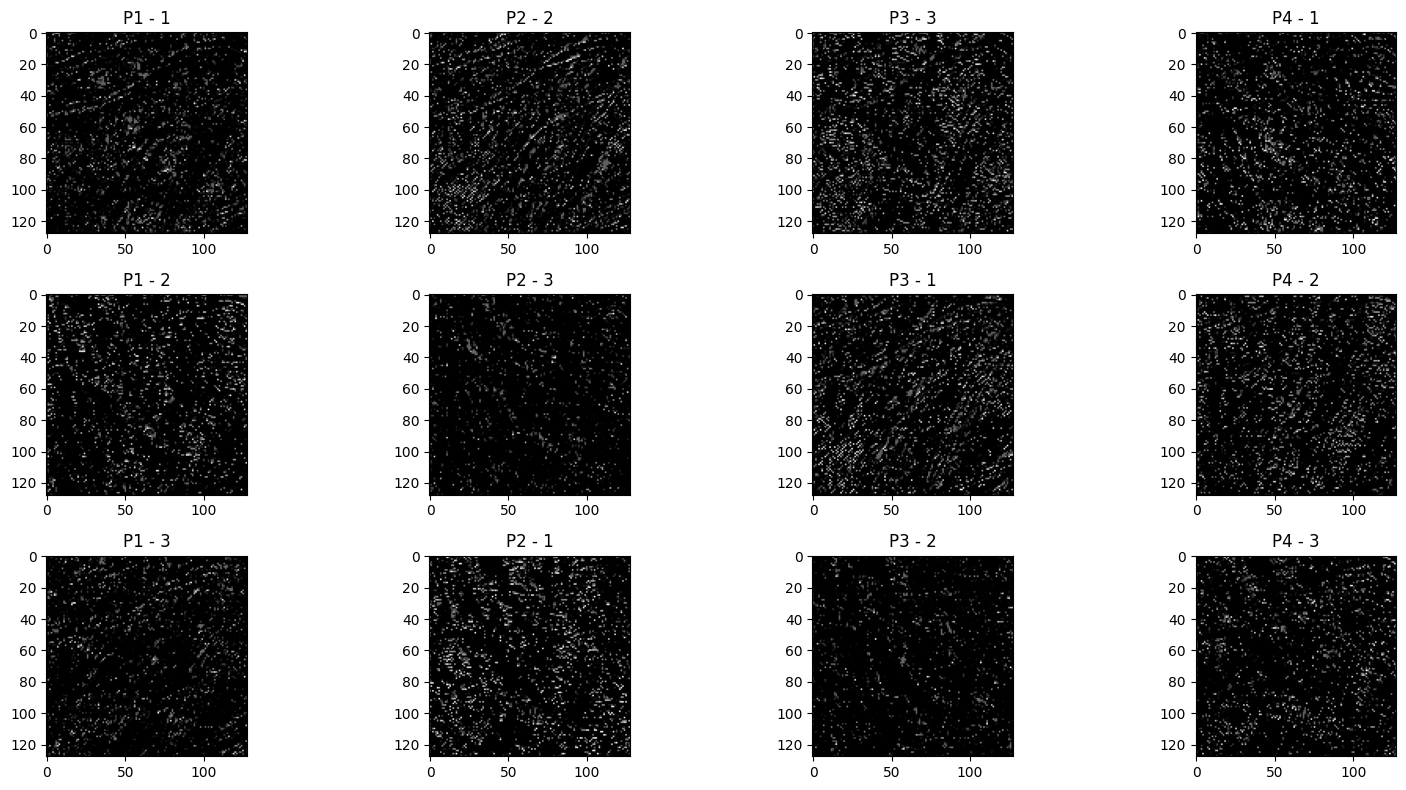

In [54]:
# # Extract LTrP2 P-components, based on the previously obtained LTrP1
ltrp2 = extract_ltrp2(ltrp1, plotting_flag=plot_figures_flag)

## [LMTrP] - Steps 6 to 9 - Extract blocks and compute histograms

In [51]:
###################################################################
def extract_ltrp2_hist(ltrp2_code, block_size=8, no_bins=8, hist_range=[0, 255]):
    """
    Extracting the block-histogram-based feature associated to every Pattern component in the Local Tetra Pattern.

    :param ltrp2_code: the previously extracted LTrP2 code. Inputshape=(P_i, image_side, image_side), where P_i represents \
    the LTrP2 code corresponding to one component). i ranges from (1..12)
    :param block_size: block size to be extracted from every P component. Default value = (8,8)
    :param no_bins: number of bins used when computing the Histogram. Default value = 8
    :param hist_range: range of values when computing the histogram. Default value = [0,255]
    :return: the extracted LTrP2-histogram feature. Output shape = (12 * n_blocks, n_blocks * n_bins)
    """
    hist_ltrp2 = []  # container for all P-component
    n_blocks = (im_side // block_size)
    for P_index, P_component in enumerate(ltrp2_code):
        # for every p component in the computed LTrP2 feature...

        p_index_feature = np.zeros((n_blocks, n_blocks * block_size))  # empty P-component container...
        block_counter = 0  # keeping track of processed blocks (within the row)
        previous_i = 0  # starting position for i, used for extracting values (updated every after every row)
        row_counter = 0  # keeping track of processed rows...

        for i in np.arange(block_size, im_side + block_size, block_size):
            row = np.array([])  # where histogram values are stored...
            previous_j = 0  # starting position for j, used for extracting values (updated every after every block)

            for j in np.arange(block_size, im_side + block_size, block_size):
                block = P_component[previous_i:i, previous_j:j]
                block_hist = cv2.calcHist([np.uint8(block)], channels=[0], mask=None,
                                          histSize=[no_bins], ranges=hist_range)

                # # used for debugging...
                # plt.plot(a_hist/np.sum(a_hist),marker='o')
                # plt.show()

                # store block histogram in row... but normalize values before!
                row = np.concatenate((row, np.reshape(np.array(block_hist / np.sum(block_hist)), (no_bins))), axis=-1)

                block_counter += 1
                previous_j = j

            p_index_feature[row_counter, :] = np.array(row)

            row_counter += 1
            previous_i = i

            del row

        p_index_feature = np.array(p_index_feature)
        hist_ltrp2.append(p_index_feature)

    # clear some memory...
    del block, block_hist, p_index_feature, P_component, ltrp2_code,
    final_h_ltrp2 = np.zeros((np.shape(hist_ltrp2)[1] *  # number of rows in each p_feature... (n_blocks)
                              np.shape(hist_ltrp2)[0],  # number of p_features (12)
                              np.shape(hist_ltrp2)[2]))  # number of bins in each histogram * n_blocks

    for hist_ltrp2_index, this_hist_ltrp2 in enumerate(hist_ltrp2):
        final_h_ltrp2[hist_ltrp2_index * np.shape(hist_ltrp2)[1]:
        (hist_ltrp2_index + 1) * np.shape(hist_ltrp2)[1], :] = this_hist_ltrp2

    return final_h_ltrp2

(192, 128)


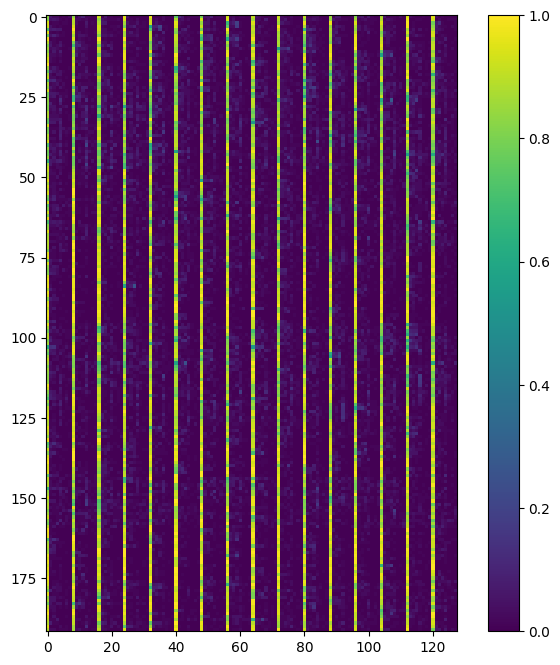

In [52]:
# # Extract histogram feature of LTrP2
ltrp2_hist = extract_ltrp2_hist(ltrp2_code=ltrp2, block_size=8, no_bins=8, hist_range=[0,255])

print(np.shape(ltrp2_hist))

plt.figure(figsize=(8,8))
plt.imshow(ltrp2_hist)
plt.colorbar()
plt.show()

## [LMTrP] - Step10 - Decompose into fewer components using Kernel-PCA

In [53]:
# # Decompose the LTrP2-histogram feature into fewer components...
pca1 = KernelPCA(n_components=128, kernel='linear')
pca2 = KernelPCA(n_components=15, kernel='linear')

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(pca1.fit_transform(X=ltrp2_hist))
plt.title('K-PCA decomposition - all components')
plt.subplot(122)
plt.imshow(pca2.fit_transform(X=ltrp2_hist))
plt.title('K-PCA decomposition - first 15 comp')
plt.show()

NameError: name 'KernelPCA' is not defined

We clearly can include most of the variation by taking into consideration the first 15 columns.

In [27]:
final_lmtrp_feature = pca2.fit_transform(X=ltrp2_hist)

## Wrap-up everything into one function

In [28]:
##################################################################
def extract_local_tetra_pattern_palm(image,
                                     input_mode='grayscale', theta_orientations=12, comp_sigma=1.5,
                                     derivative_mode='palmprint', m1=3, m2=1, plot_figures_flag=False,
                                     block_size=8, n_bins=8, h_range=[0, 255],
                                     pca_no_components=15):
    """
    Extract Local Tetra Pattern feature from input image. Optional parameters for the way of computing the image's
    derivative along its height (vertical) or width (horizontal).
    :param image: Input image, has to be grayscale. Expected to be a multiple of 8 (32,64,128,256)...
    :param input_mode: Input to the derivative algorithm. Either 'grayscale' (input image as it is), or 'gabor', in which case
    the input to the derivative algorithm is the response to the Gabor filters (using min rule).
    Default value='grayscale'
    :param theta_orientations: Number of orientations used when computing the Gabor filter response. Default value=12.
    :param comp_sigma: Sigma used to generate the bank of Gabor filters. Default value=1.5
    :param derivative_mode: Derivative computation... Either 'standard', in which case it computes dV and dH using
    1 pixel, or 'palmprint', in which case 2 more parameters need to be chosen - m1 and m2 (corresponding to line
    thickness). Check function computing derivative for more details. Default value = 'palmprint'
    :param plot_figures_flag: Flag used to display the LTrP1 and LTrP2 features. Default value=False.
    :param block_size: Size of Blocks used to break down the LTrP2-P components. Default value=8 bins.
    :param n_bins: Number of bins used to compute the histogram of values within each block. Default value=8 bins.
    :param h_range: Range used to compute the block histograms. Default value=[0,255]
    :param pca_no_components: Number of components in which the histogram-based feature is decomposed into (using
    Kernel PCA). Default value=15.
    :return: Local Tetra micro-structure Pattern feature. Output shape = (12 * n_blocks, pca_no_components).
    """
    if input_mode == 'grayscale':
        pass
    elif input_mode == 'gabor':
        # # Obtain the Gabor-filter response (using min rule) for input image.
        orientations, image = extract_compcode_with_magnitude(image, no_theta=theta_orientations, sigma=comp_sigma)
        # # normalize values
        image = (image - np.max(np.max(image))) * -1
        image = (image / np.max(np.max(image))) * 255
    else:
        raise 'Unknown value for "input_mode". Either "grayscale" or "gabor" are accepted.'
    #####################################################
    # # Compute the Derivative on the horizontal and vertical...
    #####################################################
    if derivative_mode == 'standard':
        deriv_h = derivate_image(image, 'horizontal')
        deriv_v = derivate_image(image, 'vertical')

    elif derivative_mode == 'palmprint':
        # # As was defined for Palmpritn recognition...
        deriv_h = derivate_image_palm_line(im=image, angle='horizontal', m1=m1, m2=m2)
        deriv_v = derivate_image_palm_line(im=image, angle='vertical', m1=m1, m2=m2)
    else:
        raise 'Unknown value for "derivative_mode". Either "standard" or "palmprint" are accepted.'
    ######################################################
    # # Extract LTrP1 code...
    ######################################################
    ltrp1 = extract_ltrp1(im_d_x=deriv_h, im_d_y=deriv_v)
    ######################################################
    # # Plot, if flag is True...
    ######################################################
    if plot_figures_flag:
        plt.imshow(ltrp1, cmap='jet')
        plt.colorbar()
        plt.show()

    ######################################################
    # # Extract LTrP2 P-components, based on the previously obtained LTrP1
    ######################################################

    ltrp2 = extract_ltrp2(ltrp1, plotting_flag=plot_figures_flag)

    ######################################################
    # # Extract histogram feature of LTrP2
    ######################################################
    ltrp2_hist = extract_ltrp2_hist(ltrp2_code=ltrp2, block_size=block_size, no_bins=n_bins, hist_range=h_range)

    ######################################################
    # # Decompose the LTrP2-histogram feature into fewer components...
    ######################################################
    pca = KernelPCA(n_components=pca_no_components, kernel='linear')
    decomposed_feature = pca.fit_transform(X=ltrp2_hist)

    return decomposed_feature

C:\Users\Admin\AppData\Local\Temp\ipykernel_12540\821999345.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g_c3[direction_index, i - 1, j - 1] = reduce(lambda a, b: 2 * a + b, np.array(g_dir, dtype=np.int))
C:\Users\Admin\AppData\Local\Temp\ipykernel_12540\821999345.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision

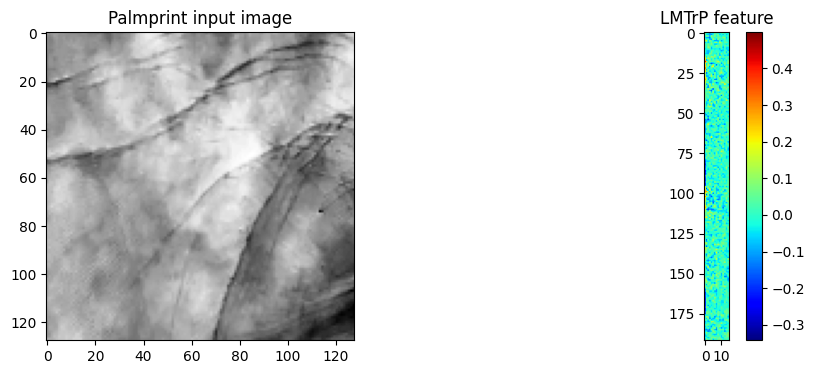

In [29]:
final_lmtrp_feature = extract_local_tetra_pattern_palm(image,
                                                 input_mode='gabor',theta_orientations=12,
                                                 comp_sigma=1.5,
                                                 derivative_mode='palmprint', m1=3,m2=1,
                                                 plot_figures_flag=False,
                                                 block_size=8,n_bins=8)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(image,'gray')
plt.title('Palmprint input image')
plt.subplot(122)
plt.imshow(final_lmtrp_feature,'jet')
plt.colorbar()
plt.title('LMTrP feature')
plt.show()